<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [1]:
!pip install pyswmm
!pip install swmmio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 1.5 MB/s 
     |████████████████████████████████| 458 kB 29.4 MB/s 
     |████████████████████████████████| 131 kB 27.3 MB/s 
  Created wheel for julian: filename=julian-0.14-py3-none-any.whl size=2633 sha256=54adfcf668c8f90510387ef22c34dc1adb8192c96c480dd176618c1ba64ac6b9
  Stored in directory: /root/.cache/pip/wheels/bb/58/2a/4109ff5870c163b26a499fb8b828ede50e96264571a4f082d3
Successfully built julian
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 4.3 MB/s 
     |████████████████████████████████| 215 kB 20.9 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-py3-none-any.whl size=32667 sha256=82d2cf4d7f4005f40b66c78efeedecf87f4dcc633a270a410857db68dd19be2a
  Stored in directory: /root/.cache/pip/wheels/a0/c5/f3/548a073ac6a83d5b23d9b39cdd243

# Import extensions

In [135]:
import os
import swmmio
import tempfile
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from swmmio.utils.text import get_inp_sections_details
from swmmio.utils.modify_model import replace_inp_section
from swmmio.version_control.utils import write_inp_section
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

# Prepare model for managing

In [136]:
#initialize a baseline model object
baseline = swmmio.Model('example.inp')
#create copy the base model 
newfilepath = os.path.join(baseline.inp.name + "_" + 'copy' + '.inp')
# save new file
baseline.inp.save(newfilepath)

# Explore model data

In [33]:
model = swmmio.Model('example_copy.inp')
df_subcatchments = dataframe_from_inp(baseline.inp.path, '[SUBCATCHMENTS]')

In [34]:
df_subcatchments[:2]

,Raingage,Outlet,...,PercSlope,CurbLength
Name,,,,,
S1,1,J1,...,10,0


In [37]:
df_subcatchments.loc["S1", "PercImperv"] = 15
model.inp.subcatchments = df_subcatchments

In [38]:
df_subcatchments[:2]

,Raingage,Outlet,...,PercSlope,CurbLength
Name,,,,,
S1,1,J1,...,10,0


In [42]:
''' PySWMM doesn't allow to set percent imprevious parameter.
It's important to check impact this feature on runoff.
This is the reason to overide imprevious value in dataftame 
and overwrite model with new data.
'''
def overwrite_percent_imprevious(value: float, subcatchment_id: str, file_path: str = 'example_copy.inp') -> None:
    model = swmmio.Model(file_path)

    #create a dataframe of the model's subcatchments
    subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')

    # subcatchments = model.subcatchments.dataframe
    subcatchments.loc[subcatchment_id, "PercImperv"] = value

    #overwrite file with new data
    swmmio.utils.modify_model.replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)

# overwrite_percent_imprevious(value=50, subcatchment_id='S1', file_path='example_copy.inp')


In [44]:
model = swmmio.Model('example_copy.inp')
sub = model.subcatchments.dataframe
sub.head()

,Raingage,Outlet,...,RouteTo,coords
Name,,,,,
S1,1,J1,...,OUTLET,"[(777172.413, 592589.245), (777181.812, 592589.633), (777181.932, 592580.323), (777172.652, 592580.174), (777172.413, 592589.364), (777172.413, 592589.245)]"


In [144]:
def calculate(subcatchment_id=None, min=0.1, max=100, step=0.1, file_path='example_copy.inp'):
    with Simulation(file_path) as sim:
        catchment = Subcatchments(sim)[subcatchment_id]
        for _ in sim: pass
        return catchment.statistics

In [145]:
def simulate_percent_imprevious(subcatchment_id=None, min=0.1, max=100, step=0.1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    percent_impervious = []
    counter = min
    while counter < max:
        model = swmmio.Model(file_path)
        subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
        subcatchments.loc[subcatchment_id, "PercImperv"] = counter
        percent_impervious += counter,
        replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
        catchment_stats = calculate(subcatchment_id=subcatchment_id, min=min, max=max, step=step, file_path=model.inp.path)
        for key in catchment_data:
            catchment_data[key].append(catchment_stats[key])
        counter += step
    catchment_data["percent_impervious"] = percent_impervious
    return pd.DataFrame(data=catchment_data)


In [148]:
def simulate_catchment_features(subcatchment_id=None, min=1, max=100, step=1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    iterator = [min]
    counter = min
    while counter < max:
        counter += step
        iterator.append(counter)
    slope, percent_impervious = [], []
    for s in iterator:
        for i in iterator:
            slope.append(s)
            percent_impervious.append(i)
            model = swmmio.Model(file_path)
            subcatchments = swmmio.utils.dataframes.dataframe_from_inp(file_path, '[SUBCATCHMENTS]')
            subcatchments.loc[subcatchment_id, "PercSlope"] = s/100
            subcatchments.loc[subcatchment_id, "PercImperv"] = i
            replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
            catchment_stats = calculate(subcatchment_id=subcatchment_id, min=min, max=max, step=step, file_path=model.inp.path)
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            counter += step
    catchment_data["slope"] = slope
    catchment_data["percent_impervious"] = percent_impervious
    return pd.DataFrame(data=catchment_data)


In [149]:
analyse = simulate_catchment_features(subcatchment_id='S1', min=1, max=100, step=10, file_path='example_copy.inp')

example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
step: 10
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
step: 10
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
step: 10
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
exa

,runoff,peak_runoff_rate,...,slope,percent_impervious
0,4147.421663,0.708872,...,1,1
1,4309.578675,0.820048,...,1,11
2,4453.766020,0.926754,...,1,21
3,4580.965259,1.027848,...,1,31
4,4690.803627,1.121749,...,1,41
...,...,...,...,...,...
116,4994.360685,1.385852,...,101,61
117,5012.356385,1.386739,...,101,71
118,5027.752483,1.387556,...,101,81
119,5039.740721,1.388346,...,101,91


In [150]:
analyse.head()

,runoff,peak_runoff_rate,...,slope,percent_impervious
0,4147.421663,0.708872,...,1,1
1,4309.578675,0.820048,...,1,11
2,4453.766020,0.926754,...,1,21
3,4580.965259,1.027848,...,1,31
4,4690.803627,1.121749,...,1,41


# Prepare methoed for analyse slope

In [ ]:
def simulate_catchments_slope(subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1, file_path='example.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    slope = []
    counter = min_slope
    while counter < max_slope:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            catchment.slope = counter
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            slope.append(counter)
            counter += step
    catchment_data["slope"] = slope
    return pd.DataFrame(data=catchment_data)


def simulate_catchment(subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1, file_path='example.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    iterator = [min_slope]
    counter = min_slope
    while counter < max_slope:
        counter += step
        iterator.append(counter)
    slope, percent_impervious, areas, runoff_total_loading = [], [], [], []
    conc_ponded, buildup, evaporation_loss = [], [], []
    for a in range(1, 30, 1):
        for s in iterator:
            for i in iterator:
                with Simulation(file_path) as sim:
                    catchment = Subcatchments(sim)[subcatchment_id]
                    catchment.slope = s
                    catchment.percent_impervious = i
                    catchment.area = a
                    runoff_total_loading.append(catchment.runoff_total_loading)
                    conc_ponded.append(catchment.conc_ponded)
                    buildup.append(catchment.buildup)
                    evaporation_loss.append(catchment.evaporation_loss)
                    slope.append(s)
                    percent_impervious.append(catchment.percent_impervious) 
                    print(catchment.percent_impervious)
                    areas.append(a)
                    for _ in sim:
                        pass
                    catchment_stats = catchment.statistics
                    for key in catchment_data:
                        catchment_data[key].append(catchment_stats[key])
        print(f"loop: {a}")
    catchment_data["slope"] = slope
    catchment_data["percent_impervious"] = percent_impervious
    catchment_data["area"] = areas
    catchment_data["runoff_total_loading"] = runoff_total_loading
    catchment_data["conc_ponded"] = conc_ponded
    catchment_data["buildup"] = buildup
    catchment_data["evaporation_loss"] = runoff_total_loading
    return pd.DataFrame(data=catchment_data)

# Get slope data

In [ ]:
slope_analyse = simulate_catchments_slope("S1", step=1)

# Subcatchments data output

## Dependence of runoff on subcatchment slope.

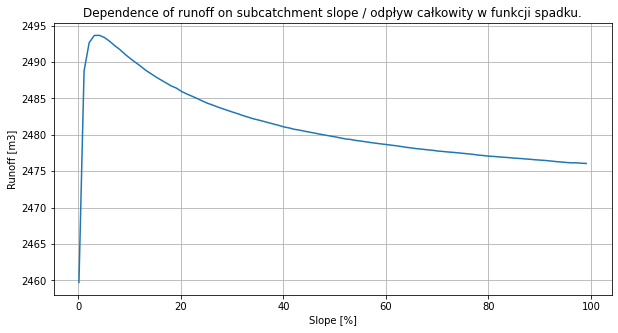

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(slope_analyse['slope'], slope_analyse['runoff'])
plt.title('Dependence of runoff on subcatchment slope / odpływ całkowity w funkcji spadku.')
plt.xlabel('Slope [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

## Dependence of peak runoff rate on subcatchment slope

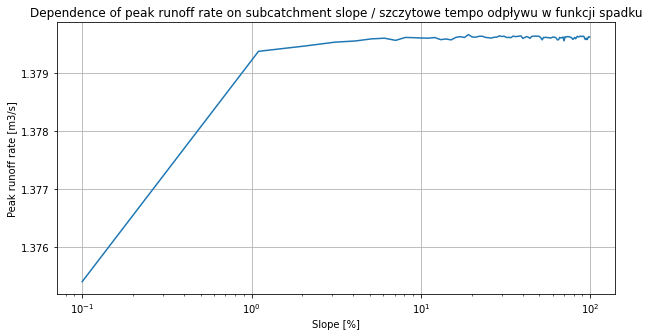

In [ ]:
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(slope_analyse['slope'], slope_analyse['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment slope / szczytowe tempo odpływu w funkcji spadku')
plt.xlabel('Slope [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

## Dependence of infiltration on subcatchment slope

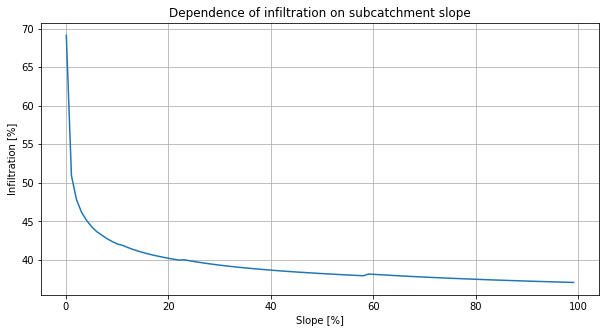

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(slope_analyse['slope'], slope_analyse['infiltration'])
plt.title('Dependence of infiltration on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

# Pipes data output

## Dependence of maximal flow on subcatchment slope.

## Dependence of maximal velocity on subcatchment slope

## Dependence of maximal pipe filling on subcatchment slope.

# Features analyse

## Show correlations betwen features as heatmap

In [154]:
df_corr = analyse.copy()
df_corr.drop(columns=['evaporation'], axis=1, inplace=True)
df_corr.head()
corr = df_corr.corr()

### Plot heatmap

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


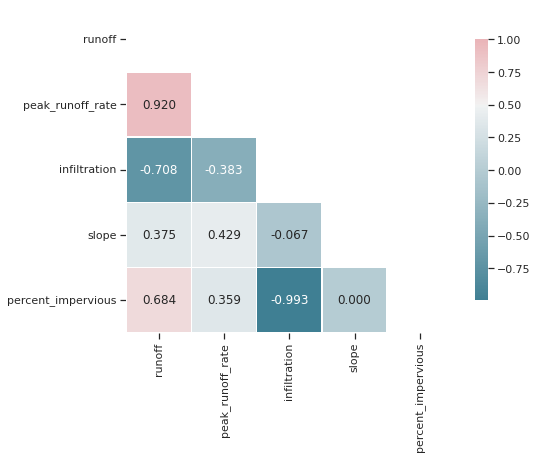

In [155]:
sns.set(style="ticks")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0.5, annot=True,
            fmt=".3f", square=True, linewidths=.5, cbar_kws={"shrink": 0.8})



```
Name
 Nazwa zlewni przypisana przez użytkownika.
 
X-Coordinate
Pozioma lokalizacja centroida zlewni na mapie obszaru opracowania. Jeśli pozostanie pusta, zlewnia nie będzie wyświetlana na mapie.
 
Y-Coordinate
 Pionowa lokalizacja centroida zlewni na mapie obszaru badań. Jeśli pozostanie pusta, zlewnia nie pojawi się na mapie.
 
Description
 Kliknąć przycisk wielokropka (lub nacisnąć Enter), aby edytować opcjonalny opis zlewni.
 
Tag
 Opcjonalna etykieta używana do kategoryzacji lub klasyfikacji zlewni.

Rain Gage
 Nazwa deszczowni powiązanej z daną zlewnią cząstkową.
 
Outlet
 Nazwa węzła lub zlewni, która odbiera odpływ z zlewni.
 
Area
 Powierzchnia zlewni cząstkowej, w tym wszelkie kontrole LID (akry lub hektary)

Width
 Charakterystyczna szerokość ścieżki przepływu lądowego dla spływu powierzchniowego (stopy lub metry).

(More...)
 
% Slope
 Średnie procentowe nachylenie zlewni.
 
% Imperv
 Procent powierzchni terenu (bez uwzględnienia jakichkolwiek LID), która jest nieprzepuszczalna.

N-Imperv
  N Manninga dla przepływu śródlądowego przez nieprzepuszczalną część zlewni cząstkowej.
 
N-Perv
 Współczynnik Manninga n dla przepływu lądowego przez nieprzepuszczalną część zlewni cząstkowej.
 
Dstore-Imperv
 Głębokość składowania wgłębnego na nieprzepuszczalnej części zlewni cząstkowej (cale lub milimetry). (Typowe wartości).
 
Dstore-Perv
 Depth of depression storage on the pervious portion of the subcatchment (inches or millimeters) (Typical Values).
 
% Zero-Imperv
 Procent obszaru nieprzepuszczalnego bez magazynowania depresji.

Subarea Routing
 Wybór wewnętrznej trasy spływu pomiędzy obszarami przepuszczalnymi i nieprzepuszczalnymi:

IMPERV: spływ z powierzchni przepuszczalnej dopływa do powierzchni nieprzepuszczalnej

PERV:      spływ z powierzchni nieprzepuszczalnej dopływa do powierzchni przepuszczalnej

OUTLET:  spływ z obu obszarów spływa bezpośrednio do wylotu
 
Percent Routed
 Procentowy udział odpływu prowadzonego pomiędzy podobszarami.
 
Infiltration
 Kliknąć przycisk wielokropka (lub nacisnąć Enter), aby edytować parametry infiltracji dla zlewni cząstkowej.
 
LID Controls

 
 Kliknąć przycisk wielokropka (lub nacisnąć Enter), aby edytować wykorzystanie kontroli rozwoju o niskim wpływie w zlewni.
 
Groundwater
 Kliknij przycisk wielokropka (lub naciśnij Enter), aby edytować parametry przepływu wód gruntowych dla zlewni cząstkowej.
 
Snow Pack
 Nazwa zestawu parametrów pakietu śniegu (jeśli istnieje) przypisanego do zlewni cząstkowej.
 
Land Uses
 Kliknij przycisk wielokropka (lub naciśnij Enter), aby przypisać użytkowanie terenu do zlewni cząstkowej. Potrzebne tylko w przypadku modelowania gromadzenia się zanieczyszczeń/odpływu wód gruntowych.
 
Initial Buildup
 Kliknij przycisk wielokropka (lub naciśnij Enter), aby określić początkowe ilości zanieczyszczeń gromadzących się w zlewni cząstkowej.
 
Curb Length
 Całkowita długość krawężników w zlewni cząstkowej (dowolne jednostki długości). Używane tylko wtedy, gdy nagromadzenie zanieczyszczeń jest normalizowane do długości krawężnika.
 
N-Perv Pattern
  Nazwa opcjonalnego miesięcznego wzorca czasowego zastosowanego do współczynnika Manninga n (N-Perv). Pozostaw puste, jeśli nie ma zastosowania.
 
Dstore Pattern
  Nazwa opcjonalnej miesięcznej korekty wzorca czasu stosowanej do obu wartości magazynowania depresji (Dstore). Pozostawić puste, jeśli nie dotyczy.
 
Infil. Pattern
 Nazwa opcjonalnej miesięcznej korekty Time Pattern zastosowanej do przewodności hydraulicznej powierzchni przepuszczalnej. Pozostawić puste, jeśli nie dotyczy.
 



```





```
# Sformatowano jako kod
Name
 User-assigned subcatchment name.
 
X-Coordinate
 Horizontal location of the subcatchment's centroid on the Study Area Map. If left blank then the subcatchment will not appear on the map.
 
Y-Coordinate
 Vertical location of the subcatchment's centroid on the Study Area Map. If left blank then the subcatchment will not appear on the map.
 
Description
 Click the ellipsis button (or press Enter) to edit an optional description of the subcatchment.
 
Tag
 Optional label used to categorize or classify the subcatchment.
 
Rain Gage
 Name of the rain gage associated with the subcatchment.
 
Outlet
 Name of the node or subcatchment that recieves the subcatchment's runoff.
 
Area
 Area of the subcatchment, including any LID controls (acres or hectares).
 
Width
 Characteristic width of the overland flow path for sheet flow runoff (feet or meters).

(More...)
 
% Slope
 Average percent slope of the subcatchment.
 
% Imperv
 Percent of the land area (not including any LIDs) which is impervious.
 
N-Imperv
 Manning's n for overland flow over the impervious portion of the subcatchment.

(Typical Values).
 
N-Perv
 Manning's n for overland flow over the pervious portion of the subcatchment.

(Typical Values).
 
Dstore-Imperv
 Depth of depression storage on the impervious portion of the subcatchment (inches or millimeters). (Typical Values).
 
Dstore-Perv
 Depth of depression storage on the pervious portion of the subcatchment (inches or millimeters) (Typical Values).
 
% Zero-Imperv
 Percent of the impervious area with no depression storage.
 
Subarea Routing
 Choice of internal routing of runoff between pervious and impervious areas:

IMPERV: runoff from pervious area flows to impervious area

PERV:      runoff from impervious flows to pervious area

OUTLET:  runoff from both areas flows directly to outlet
 
Percent Routed
 Percent of runoff routed between subareas.
 
Infiltration
 Click the ellipsis button (or press Enter) to edit infiltration parameters for the subcatchment.
 
LID Controls

 
 Click the ellipsis button (or press Enter) to edit the use of low impact development controls in the subcatchment.
 
Groundwater
 Click the ellipsis button (or press Enter) to edit groundwater flow parameters for the subcatchment.
 
Snow Pack
 Name of snow pack parameter set (if any) assigned to the subcatchment.
 
Land Uses
 Click the ellipsis button (or press Enter) to assign land uses to the subcatchment. Only needed if pollutant buildup/washoff modeled.
 
Initial Buildup
 Click the ellipsis button (or press Enter) to specify initial quantities of pollutant buildup over the subcatchment.
 
Curb Length
 Total length of curbs in the subcatchment (any length units). Used only when pollutant buildup is normalized to curb length.
 
N-Perv Pattern
 Name of optional monthly Time Pattern adjustments applied to pervious Manning's n (N-Perv). Leave blank if not applicable.
 
Dstore Pattern
 Name of optional monthly Time Pattern adjustments applied to both depression storage (Dstore) values. Leave blank if not applicable.
 
Infil. Pattern
 Name of optional monthly Time Pattern adjustments applied to the pervious area's hydraulic conductivity. Leave blank if not applicable.
 

```

